In [2]:
import numpy as np
import pandas as pd
import dimod
from dimod import BinaryQuadraticModel
from dimod.reference.samplers import SimulatedAnnealingSampler


df_dist = pd.read_csv(r'C:\Sagar\\Github\\Quantum_Startup1\data\distance_matrix.csv', header=0)
distances = df_dist.values
print(distances.shape)

df_wh = pd.read_csv(r'C:\Sagar\\Github\\Quantum_Startup1\data\warehouses.csv', header=0)
df_cust = pd.read_csv(r'C:\Sagar\\Github\\Quantum_Startup1\data\\customers.csv', header=0)

capacities = df_wh['Capacity'].values  # shape: (num_warehouses,)
demands    = df_cust['Demand'].values   # shape: (num_customers,)

num_wh, num_cust = distances.shape
print(distances.shape)


(50, 100)
(50, 100)


In [4]:
# 2. Decision variables: y_{w,c} = 1 if warehouse w serves customer c
#    Flattened into dict for BQM indexing

y = {(w, c): f'y_{w}_{c}'
     for w in range(num_wh)
     for c in range(num_cust)}

# 3. Build Binary Quadratic Model
bqm = BinaryQuadraticModel(vartype=dimod.BINARY)

# Objective: minimize total travel distance
distance_weight = 1.0
for (w, c), var in y.items():
    bqm.add_linear(var, distance_weight * distances[w, c])

# 4. Penalty weights
A = 10.0  # assignment (each customer exactly one warehouse)
B = 1.0   # capacity (warehouse capacity constraints)

# 5. Constraint: each customer must be assigned to exactly one warehouse
for c in range(num_cust):
    vars_c = [y[(w, c)] for w in range(num_wh)]
    # penalty: (sum_w y_{w,c} - 1)^2 = sum_i x_i + 2 sum_{i<j} x_i x_j - 2 sum_i x_i + 1
    # linear terms
    for var in vars_c:
        bqm.add_linear(var, -A)
    # quadratic terms
    for i in range(len(vars_c)):
        for j in range(i + 1, len(vars_c)):
            bqm.add_quadratic(vars_c[i], vars_c[j], 2 * A)
    # constant offset
    bqm.offset += A



In [5]:

# 6. Constraint: warehouse capacity not exceeded
#    penalty: (sum_c demand[c] * y_{w,c} - capacity[w])^2
for w in range(num_wh):
    vars_w = [y[(w, c)] for c in range(num_cust)]
    cap = capacities[w]
    # linear terms: demand[i]^2 - 2*cap*demand[i]
    for i, var in enumerate(vars_w):
        d_i = demands[i]
        bqm.add_linear(var, B * (d_i**2 - 2 * cap * d_i))
    # quadratic terms: 2 * demand[i] * demand[j]
    for i in range(len(vars_w)):
        for j in range(i + 1, len(vars_w)):
            bqm.add_quadratic(vars_w[i], vars_w[j], 2 * B * demands[i] * demands[j])
    # constant offset
    bqm.offset += B * (cap**2)



In [10]:
# 7. Solve with Simulated Annealing
from dwave.samplers import TabuSampler

sampler = TabuSampler()
sampleset = sampler.sample(bqm, num_reads=1)


In [11]:
# 8. Extract best solution
best = sampleset.first.sample
assignments = [(w, c) for (w, c), var in y.items() if best[var] == 1]
total_cost = sum(distances[w, c] for (w, c) in assignments)

print(f"Assignments (w,c): {assignments}")
print(f"Total distance cost: {total_cost:.2f} km")

Assignments (w,c): [(0, 1), (0, 2), (0, 3), (0, 5), (0, 7), (0, 8), (0, 11), (0, 13), (0, 14), (0, 18), (0, 19), (0, 21), (0, 22), (0, 23), (0, 25), (0, 27), (0, 29), (0, 35), (0, 38), (0, 42), (0, 44), (0, 49), (0, 51), (0, 55), (0, 58), (0, 60), (0, 61), (0, 64), (0, 78), (0, 79), (0, 80), (0, 81), (0, 83), (0, 85), (0, 87), (0, 88), (0, 90), (0, 92), (0, 94), (0, 95), (0, 98), (0, 99), (1, 1), (1, 2), (1, 3), (1, 4), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 13), (1, 16), (1, 17), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 25), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 35), (1, 37), (1, 39), (1, 41), (1, 43), (1, 44), (1, 48), (1, 50), (1, 51), (1, 53), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (1, 61), (1, 64), (1, 65), (1, 67), (1, 69), (1, 71), (1, 74), (1, 75), (1, 76), (1, 78), (1, 79), (1, 82), (1, 85), (1, 86), (1, 87), (1, 88), (1, 90), (1, 91), (1, 92), (1, 93), (1, 95), (1, 97), (1, 98), (1, 99), (2, 2), (2, 4), (2, 5), (2, 7), (2, 9), (2, 11),

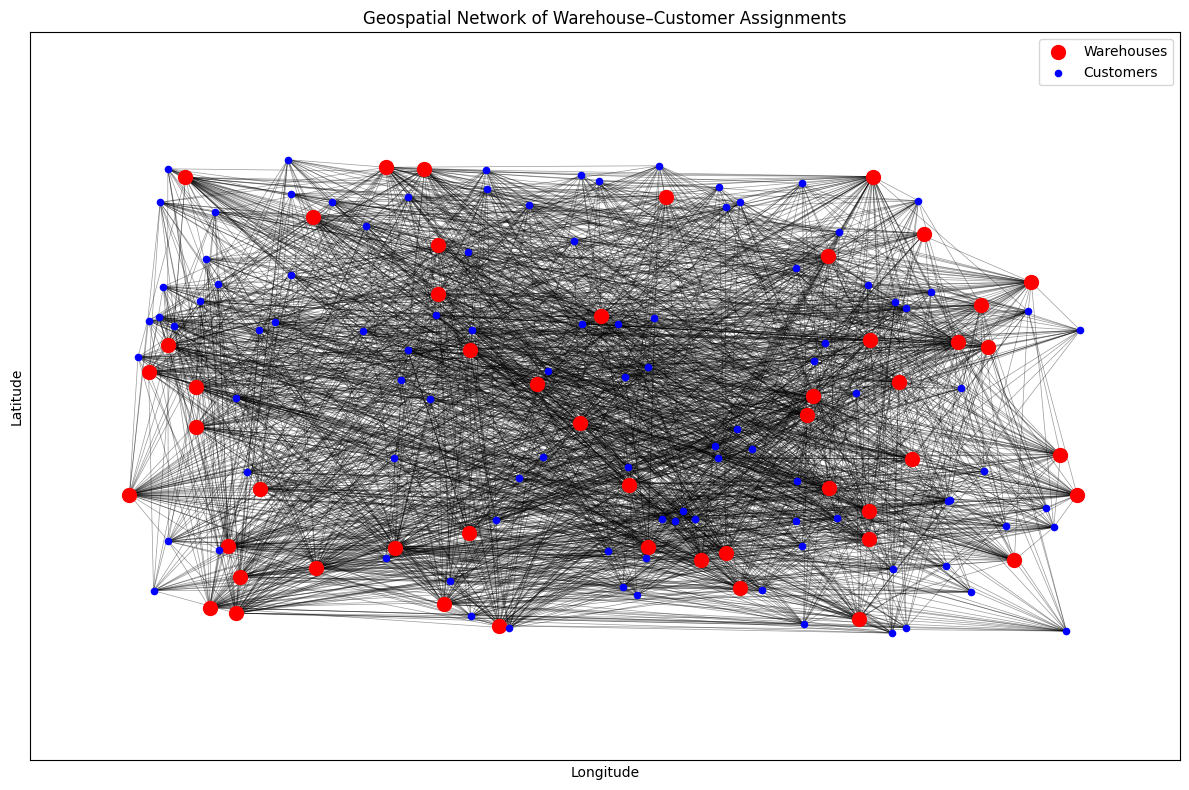

In [15]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1) Load your data (adjust paths to wherever your CSVs live):
df_wh   = pd.read_csv(r'C:\Sagar\Github\Quantum_Startup1\data\warehouses.csv', header=0)
df_cust = pd.read_csv(r'C:\Sagar\Github\Quantum_Startup1\data\customers.csv',  header=0)

# 2) Build the assignment list if you haven’t already:
#    assignments = [(w,c), (w,c), …]  # your list of (warehouse_index, customer_index)

# 3) Map from indices to IDs and back
#    (so we can find each ID’s lon/lat easily)
df_assign = pd.DataFrame(assignments, columns=['w_idx','c_idx'])
df_assign['WID'] = df_assign['w_idx'].apply(lambda w: df_wh.at[w,'Warehouse_ID'])
df_assign['CID'] = df_assign['c_idx'].apply(lambda c: df_cust.at[c,'Customer_ID'])

# 4) Create bipartite graph with real‐world “pos”
G = nx.Graph()
# add nodes with their real coords as positions
pos = {}
for _, row in df_wh.iterrows():
    node = f"W{int(row.Warehouse_ID)}"
    G.add_node(node)
    pos[node] = (row.Longitude, row.Latitude)
for _, row in df_cust.iterrows():
    node = f"C{int(row.Customer_ID)}"
    G.add_node(node)
    pos[node] = (row.Longitude, row.Latitude)

# add edges for each assignment
for _, row in df_assign.iterrows():
    G.add_edge(f"W{int(row.WID)}", f"C{int(row.CID)}")

# 5) Draw it
plt.figure(figsize=(12,8))
# draw edges first (so nodes sit on top)
nx.draw_networkx_edges(G, pos, alpha=0.4, width=0.5)

# draw the two types of nodes
nx.draw_networkx_nodes(G, pos,
    nodelist=[n for n in G.nodes() if n.startswith('W')],
    node_color='red',    node_size=100, label='Warehouses')
nx.draw_networkx_nodes(G, pos,
    nodelist=[n for n in G.nodes() if n.startswith('C')],
    node_color='blue',   node_size=20,  label='Customers')

plt.legend(scatterpoints=1)
plt.title("Geospatial Network of Warehouse–Customer Assignments")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis('equal')
plt.tight_layout()
plt.show()


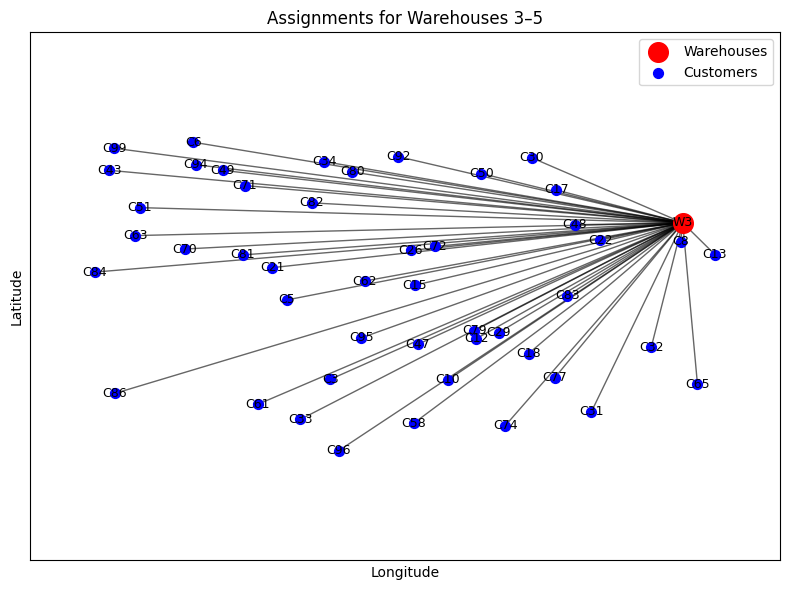

In [19]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1. Reload data
df_dist = pd.read_csv(r'C:\Sagar\Github\Quantum_Startup1\data\distance_matrix.csv', header=0)
distances = df_dist.values
df_wh   = pd.read_csv(r'C:\Sagar\Github\Quantum_Startup1\data\warehouses.csv', header=0)
df_cust = pd.read_csv(r'C:\Sagar\Github\Quantum_Startup1\data\customers.csv',  header=0)

# 2. Rebuild your QUBO and sampler (use your previous code exactly here)
#    [Insert cells 2–7 from your notebook to recreate `bqm` and `sampleset`]

# For brevity, here’s how to extract assignments if you already have `sampleset`:
best = sampleset.first.sample
assignments = [(w, c) for (w, c), var in y.items() if best[var] == 1]

# 3. Map assignment indices to real IDs
df_assign = pd.DataFrame(assignments, columns=['w_idx','c_idx'])
df_assign['WID'] = df_assign['w_idx'].apply(lambda w: df_wh.at[w, 'Warehouse_ID'])
df_assign['CID'] = df_assign['c_idx'].apply(lambda c: df_cust.at[c, 'Customer_ID'])

# 4. Filter for warehouses 3–5
selected_wh = [3]
df_sub = df_assign[df_assign['WID'].isin(selected_wh)]

# 5. Build the graph & pos dict
G = nx.Graph()
pos = {}
for _, row in df_wh[df_wh['Warehouse_ID'].isin(selected_wh)].iterrows():
    node = f"W{int(row.Warehouse_ID)}"
    G.add_node(node)
    pos[node] = (row.Longitude, row.Latitude)
for _, row in df_cust[df_cust['Customer_ID'].isin(df_sub['CID'].unique())].iterrows():
    node = f"C{int(row.Customer_ID)}"
    G.add_node(node)
    pos[node] = (row.Longitude, row.Latitude)
for _, row in df_sub.iterrows():
    G.add_edge(f"W{int(row.WID)}", f"C{int(row.CID)}")

# 6. Plot
plt.figure(figsize=(8,6))
nx.draw_networkx_edges(G, pos, alpha=0.6)
nx.draw_networkx_nodes(G, pos,
                       nodelist=[n for n in G if n.startswith('W')],
                       node_color='red', node_size=200, label='Warehouses')
nx.draw_networkx_nodes(G, pos,
                       nodelist=[n for n in G if n.startswith('C')],
                       node_color='blue', node_size=50, label='Customers')
nx.draw_networkx_labels(G, pos, font_size=9)
plt.legend(scatterpoints=1)
plt.title("Assignments for Warehouses 3–5")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis('equal')
plt.tight_layout()
plt.show()
